In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import pymap3d as pm

# Creating empty data frames for each model
roll_model = pd.DataFrame()
pitch_model = pd.DataFrame()
plunge_model = pd.DataFrame()
yaw_model = pd.DataFrame()
full_model = pd.DataFrame()

# ------------------------------------------------
# The general function of this data parser is to
# take dji drone data, perform calculations on it,
# and export it to a useable format for 
# system identification in MATLAB
# ------------------------------------------------

# def calculate_moments(RCIN):
    
#     rows,cols = RCIN.shape

#     roll_input = np.zeros(rows); pitch_input = np.zeros(rows); plunge_input = np.zeros(rows); yaw_input = np.zeros(rows)
#     t = np.zeros(rows)
#     for i in range(0,rows):                                       # Fills input arrays for different motions
#         t[i] = RCIN.iloc[i,0]
#         roll_input[i] = RCIN.iloc[i,4]
#         pitch_input[i] = RCIN.iloc[i,3]
#         plunge_input[i] = RCIN.iloc[i,5]
#         yaw_input[i] = RCIN.iloc[i,6]
    
#     nominal_roll_input = 1024                          # Nominal inputs are found when the drone is in hover mode
#     nominal_pitch_input = 1024                          # which is seen at the beggining of our flight test.
#     nominal_plunge_input = 1024                       # Therefore initial values are used as nominal input
#     nominal_yaw_input = 1024
    
#     max_PWM = 1600                                               # Max and Min used to noramlize the input vector.
#     min_PWM = 364                                           # Determined by recording the input values at max and min
#     PWM_diff = max_PWM - min_PWM                                  # throttle using no propellors

#     for i in range(0,rows):
#         µ_roll[i] = (nominal_roll_input - roll_input[i])/PWM_diff           # Uses formula (PWM_nom - PWM_exc)/PWM_max_min_diff
#         µ_pitch[i] = (nominal_pitch_input  - pitch_input[i])/PWM_diff       # to solve for input vectors for the four motions
#         µ_plunge[i] = (nominal_plunge_input - plunge_input[i])/PWM_diff
#         µ_yaw[i] = (nominal_yaw_input - yaw_input[i])/PWM_diff
    
#     plunge_mean = np.mean(µ_plunge)
#     yaw_mean = np.mean(µ_yaw)
#     for i in range(0,rows):    
#         µ_plunge[i] = µ_plunge[i] - plunge_mean
#         µ_yaw[i] = µ_yaw[i] - yaw_mean 

#     return µ_roll, µ_pitch, µ_plunge, µ_yaw

def calculate_moments(RCIN): 
   
    # ------------------------------------------------------------
    # I've changed the moment calculation to just be taking the 
    # percentage for each motor input. This should be the correct
    # calculation, but it could be worth it to do some more
    # digging into this change.
    # ------------------------------------------------------------
    
    rows,cols = RCIN.shape
    
    µ_roll = np.zeros(rows)
    µ_pitch = np.zeros(rows)
    µ_plunge = np.zeros(rows)
    µ_yaw = np.zeros(rows)
    
    for i in range(0,rows):
        µ_roll[i] = RCIN.iloc[i,32] * .01
        µ_pitch[i] = RCIN.iloc[i,31] * .01
        µ_plunge[i] = RCIN.iloc[i,33] * .01
        µ_yaw[i] = RCIN.iloc[i,34] * .01

    return µ_roll, µ_pitch, µ_plunge, µ_yaw

def export_model_df(dataframe, dataframe_name):
    
    # This function exports a model to an output csv
    
    path_dir = 'Data_Exports/' + 'dji' + '/' + dataframe_name + '_output.csv' # Exports data if doesnt already exists
    dataframe.to_csv(path_dir)
    print(dataframe_name + " data has successfully been saved to an excel file.\n")

def dji_data_parser():
    #----------------------------------------------------------
    # Step 0: Import dji flight log
    #----------------------------------------------------------  
    # TO DO: create input file input
    dji = pd.DataFrame(pd.read_csv('Downloads/Feb-15th-2023-12-14PM-Flight-Airdata.csv'))
    rows,cols = dji.shape
    #----------------------------------------------
    # Step 1: Parse timestamps
    #----------------------------------------------
    timestamp = []

    # Each row is 1 second of data in this situation
    time = dji.iloc[0,1]
    hrs = int(time[11:12])*60*60*1000
    mins = int(time[14:15])*60*1000
    sec = int(time[17:18])*1000
    ms = 0
    for i in range(0,rows):
        if i != 0:
            ms += 100
        timestamp.append(hrs + mins + sec + ms)

    #-----------------------------------------------------------------------------------------------------------------
    # Step 2 - Obtain Derivatives for System Identification
    #-----------------------------------------------------------------------------------------------------------------
    # Obtain attitude angles and VD using NKF1 to take derivatives for angular acceleration and acceleration in z-axis   
    roll = np.zeros(rows) ; pitch = np.zeros(rows); yaw = np.zeros(rows); VD = np.zeros(rows)
    for i in range(0,rows):                       
        roll[i] = dji.iloc[i,24]*0.0174533                                  # rad
        pitch[i] = dji.iloc[i,23]*0.0174533                                 # rad
        yaw[i] = dji.iloc[i,22]*0.0174533                                   # rad
        VD[i] = dji.iloc[i,21]*0.44704                                   # m/s

    # First Derivatives (Angular Velocities and Acceleration in z-axis)
    dRdt = np.gradient(roll)*20                                  # rad/s
    dPdt = np.gradient(pitch)*20                                 # rad/s
    dYdt = np.gradient(yaw)*20                                   # rad/s
    dVDdt = np.gradient(VD)*20                                   # m/s^2

    # Second Derivatives (Angular Accelerations)
    dRdt2 = np.gradient(dRdt)*20                                 # rad/s^2
    dPdt2 = np.gradient(dPdt)*20                                 # rad/s^2
    dYdt2 = np.gradient(dYdt)*20                                 # rad/s^2

    # Obtain Translational Acceleration using Ground Speed from GPS data set
    v = np.zeros(rows) 
    alt = np.zeros(rows)
    for i in range(0,rows):
        v[i] = dji.iloc[i,9]*0.44704                                   # m/s
        alt[i] = dji.iloc[i,4]*0.3048               # m

    # First Derivative (Translational Acceleration)
    dvdt = np.gradient(v)*20                                     # m/s^2
    #-------------------------------------------------
    # Step 3: Gather data for different motion models
    #-------------------------------------------------
    # Already have attitiude angles, VD, and translational velocity from above
    # Gather the rest of position and velocity terms from NKF1

    rows,cols = dji.shape
    VN = np.zeros(rows); VE = np.zeros(rows)
    PN = np.zeros(rows); PE = np.zeros(rows); PD = np.zeros(rows)

    seconds_from_start = np.zeros(rows)


    for i in range(0,rows):
        seconds_from_start[i] = dji.iloc[i,0]*.001
        VN[i] = dji.iloc[i,20]
        VE[i] = dji.iloc[i,19]
        lat = dji.iloc[i,2]
        lon = dji.iloc[i,3]
        alt = dji.iloc[i,4]*0.3048
        x,y,z = pm.geodetic2ecef(lat,lon,alt)
        if i == 0:
            PN[i] = y
            PE[i] = x
            PD[i] = z
        else:
            PN[i] = y - PN[0]
            PE[i] = x - PE[0]
            PD[i] = z - PD[0]

    # First Derivatives (Translational Accelerations)
    dVNdt = np.gradient(VN) * 20                                 # m/s^2
    dVEdt = np.gradient(VE) * 20                                 # m/s^2

    # Calculating motion moments using RCIN and RCOU values
    µ_roll, µ_pitch, µ_plunge, µ_yaw = calculate_moments(dji) 
            

    # Already have angular rates from differentiation of attitude above
    #----------------------------------------------------------------------------------------------------------------- 
    # Step 4: Build dataframes for each motion model
    #-----------------------------------------------------------------------------------------------------------------
    # Motion Model 1: Roll - (Roll Acceleration, PE, Roll Angle(φ), VE, Roll Speed(p), µ_roll)
    #-----------------------------------------------------------------------------------------
    roll_model['Timestamp'] = timestamp
    roll_model['(d/dt)p'] = dRdt2
    roll_model['(d/dt)VE'] = dVEdt
    roll_model['PE'] = PE
    roll_model['Roll'] = roll
    roll_model['VE'] = VE
    roll_model['p'] = dRdt
    roll_model['Mu_roll'] = µ_roll
    roll_model['Flight Time (s)'] = seconds_from_start

    # Motion Model 2: Pitch - (Pitch Acceleration, PN, Pitch Angle(θ), VN, Pitch Speed(q), µ_pitch)
    #-----------------------------------------------------------------------------------------------
    pitch_model['Timestamp'] = timestamp
    pitch_model['(d/dt)q'] = dPdt2
    pitch_model['(d/dt)VN'] = dVNdt
    pitch_model['PN'] = PN
    pitch_model['Pitch'] = pitch
    pitch_model['VN'] = VN
    pitch_model['q'] = dPdt
    pitch_model['Mu_pitch'] = µ_pitch
    pitch_model['Flight Time (s)'] = seconds_from_start

    # Motion Model 3: Plunge - (Vert Acceleration, PD, VD, µ_plunge)
    #---------------------------------------------------------------
    plunge_model['Timestamp'] = timestamp
    plunge_model['(d/dt)VD'] = dVDdt
    plunge_model['PD'] = PD
    plunge_model['VD'] = VD
    plunge_model['Mu_plunge'] = µ_plunge
    plunge_model['Flight Time (s)'] = seconds_from_start

    # Motion Model 4: Yaw - (Yaw Acceleration, Yaw Angle(ψ), Translational Velocity(v), Yaw Speed(r), µ_yaw)
    #-------------------------------------------------------------------------------------------------------
    yaw_model['Timestamp'] = timestamp
    yaw_model['(d/dt)r'] = dYdt2
    yaw_model['(d/dt)v'] = dvdt
    yaw_model['Yaw'] = yaw
    yaw_model['v'] = v
    yaw_model['r'] = dYdt
    yaw_model['Mu_yaw'] = µ_yaw
    yaw_model['Flight Time (s)'] = seconds_from_start

    # Full Model
    #-------------------------------------------------------------------------------------------------------
    full_model['Timestamp'] = timestamp
    full_model['x'] = PN
    full_model['y'] = PE
    full_model['z'] = PD
    full_model['theta'] = pitch
    full_model['phi'] = roll
    full_model['psi'] = yaw
    full_model['u'] = VN
    full_model['v'] = VE
    full_model['w'] = VD
    full_model['q'] = dPdt
    full_model['p'] = dRdt
    full_model['r'] = dYdt
    full_model['Mplunge'] = µ_plunge
    full_model['Mpitch'] = µ_pitch
    full_model['Mroll'] = µ_roll
    full_model['Myaw'] = µ_yaw
    full_model['Alt'] = alt
    full_model['Flight Time (s)'] = seconds_from_start

def plot_data(motion_model_int,motion_model):
    str_motion = ""
    motion = []
    time = []
    if motion_model_int == 0:
        str_motion = 'Roll'
        motion = motion_model['Roll']
        time = motion_model['Flight Time (s)']
    if motion_model_int == 1:
        str_motion = 'Pitch'
        motion = motion_model['Pitch']
        time = motion_model['Flight Time (s)']
    if motion_model_int == 2:
        str_motion = 'Yaw'
        motion = motion_model['Yaw']
        time = motion_model['Flight Time (s)']
    if motion_model_int == 3:
        str_motion = 'Plunge'
        motion = motion_model['VD']
        time = motion_model['Flight Time (s)']
    
    plt.plot(time,motion)
    plt.title(str_motion + ' vs Time')
    plt.xlabel('Time (seconds)')
    if str_motion != 'Plunge':
        plt.ylabel(str_motion + ' (degrees)')
    else:
        plt.ylabel(str_motion + ' (meters per second)')
    plt.show()
    plt.plot(time,motion_model['PE'])
    plt.title('PE vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('PE (meters)')
    plt.show()

def motion_model_export(motion_model,truncated_model):
    if motion_model == 0:
        export_model_df(truncated_model, 'Roll_Model')
    if motion_model == 1:
        export_model_df(truncated_model, 'Pitch_Model')
    if motion_model == 2:
        export_model_df(truncated_model, 'Yaw_Model')
    if motion_model == 3:
        export_model_df(truncated_model, 'Plunge_Model')
        
def assign_truncated_model(motion_model,truncated_model):
    if motion_model == 0:
        roll_model = truncated_model
    if motion_model == 1:
        pitch_model = truncated_model
    if motion_model == 2:
        yaw_model = truncated_model
    if motion_model == 3:
        plunge_model = truncated_model
    
def user_interface():
    
    # This is the user interface. This is
    # the function that makes this data 
    # parsers useable to people who don't really know
    # python or even code, but can still export a drone
    # motion model 
    
    dji_data_parser()
    
    print("Do you want to export motion model data?")
    print("---------------------------")
    print("Select 0 for No, 1 for Yes")
    print("---------------------------")
    export_data = int(input("Export Data?: "))
    if export_data == 1:
        
        # TO DO: create input file input
    
        print("What motion model do you want to export?")
        print("-------------------------------------------------------------")
        print("Select 0 for Roll, 1 for Pitch, 2 for Yaw, and 3 for Plunge:")
        print("-------------------------------------------------------------")
        # TO DO: Error catch
        motion_model = int(input("Motion Model: "))

        print("Do you want to graph data?")
        print("---------------------------")
        print("Select 0 for No, 1 for Yes")
        print("---------------------------")
        # TO DO: Error catch
        graph_data = int(input("Graph Data?: "))

        if graph_data == 1:
            if motion_model == 0:
                plot_data(motion_model,roll_model)
            if motion_model == 1:
                plot_data(motion_model,pitch_model)
            if motion_model == 2:
                plot_data(motion_model,yaw_model)
            if motion_model == 3:
                plot_data(motion_model,plunge_model)

        print("Do you want to truncate data?")
        print("---------------------------")
        print("Select 0 for No, 1 for Yes")
        print("---------------------------")
        truncate_data = int(input("Truncate Data?: "))
        
        # TO DO: Create while loop and figure out how to 
        # continuously truncate data
        loop = True
        while loop == True:
            if truncate_data == 1:
                # Create error catching
                print("What range of values do you want to truncate?")
                start = int(input("Start value: "))
                end = int(input("End value: "))
                time = np.array([])
                motion = np.array([])
                if motion_model == 0:
                    motion = roll_model['Roll']
                    time = roll_model['Flight Time (s)']
                if motion_model == 1:
                    motion = pitch_model['Pitch']
                    time = pitch_model['Flight Time (s)']
                if motion_model == 2:
                    motion = yaw_model['Yaw']
                    time = yaw_model['Flight Time (s)']
                if motion_model == 3:
                    motion = plunge_model['VD']
                    time = plunge_model['Flight Time (s)']
                index_array = []
                for i in range(len(time)):
                    if time[i] >= start and time[i] <= end:
                        index_array.append(i)
                start_index = index_array[0]
                end_index = index_array[-1]
                truncated_roll_model = pd.DataFrame()
                truncated_pitch_model = pd.DataFrame()
                truncated_plunge_model = pd.DataFrame()
                truncated_yaw_model = pd.DataFrame()
                if motion_model == 0:
                    truncated_roll_model = roll_model.truncate(before=start_index, after=end_index)
                if motion_model == 1:
                    truncated_pitch_model = pitch_model.truncate(before=start_index, after=end_index)
                if motion_model == 2:
                    truncated_yaw_model = yaw_model.truncate(before=start_index, after=end_index)
                if motion_model == 3:
                    truncated_plunge_model = plunge_model.truncate(before=start_index, after=end_index)
                plot_data(motion_model,truncated_roll_model)
                print("Do you want to keep truncating data?")
                print("---------------------------")
                print("Select 0 for No, 1 for Yes")
                print("---------------------------")
                loop_data = int(input("Keep Truncating Data?: "))

        if motion_model == 0:
            motion_model_export(motion_model,truncated_roll_model)
        if motion_model == 1:
            motion_model_export(motion_model,truncated_pitch_model)
        if motion_model == 2:
            motion_model_export(motion_model,truncated_yaw_model)
        if motion_model == 3:
            motion_model_export(motion_model,truncated_plunge_model)
    

SyntaxError: invalid syntax (4219081205.py, line 20)

Do you want to export motion model data?
---------------------------
Select 0 for No, 1 for Yes
---------------------------
Export Data?: 1
What motion model do you want to export?
-------------------------------------------------------------
Select 0 for Roll, 1 for Pitch, 2 for Yaw, and 3 for Plunge:
-------------------------------------------------------------
Motion Model: 0
Do you want to graph data?
---------------------------
Select 0 for No, 1 for Yes
---------------------------
Graph Data?: 0
Do you want to truncate data?
---------------------------
Select 0 for No, 1 for Yes
---------------------------
Truncate Data?: 1
What range of values do you want to truncate?
Start value: 140
End value: 160


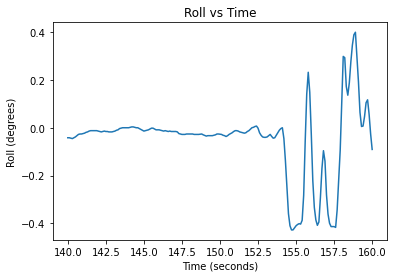

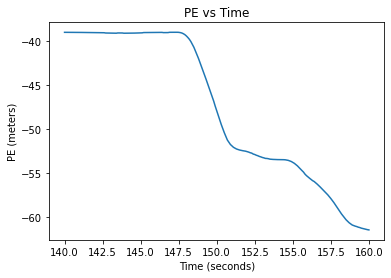

Roll_Model data has successfully been saved to an excel file.



In [2]:
user_interface()